# Unzip file

# Install Library

In [2]:
!pip install prophet pandas-profiling
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

color_pallet = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
train_path = '/content/demand_forecasting_train.csv'
train_profile_path = 'train_profile.html'
save_model_path = 'serialized_model.json'

In [5]:
import IPython
import pandas as pd
from prophet import Prophet
from pandas_profiling import ProfileReport
from sklearn.metrics import  mean_absolute_error

<ipython-input-5-8367f76eda37>:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


## Problem Definition and Data Wragling

given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

the dependent variable would be sales and the problem type should be time series

In [28]:
train_df = pd.read_csv(train_path)
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## EDA

In [29]:
prof = ProfileReport(train_df)
prof.to_file(output_file=train_profile_path)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
IPython.display.HTML(filename=train_profile_path)

Number of variables,4
Number of observations,913000
Missing cells,0
Missing cells (%),0.0%
Duplicate rows,0
Duplicate rows (%),0.0%
Total size in memory,27.9 MiB
Average record size in memory,32.0 B
Categorical,1
Numeric,3
date has a high cardinality: 1826 distinct values,High cardinality


the model design will be skip since prophet will handdle this part

## Feature Engineering

In [31]:
def preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    df = df.groupby('date').sum('sales')
    df.index = pd.to_datetime(df.index)
    df = df.drop(['store','item'], axis=1)
    return df

In [32]:
train_df = preprocessing(train_df)

plot sales over the period

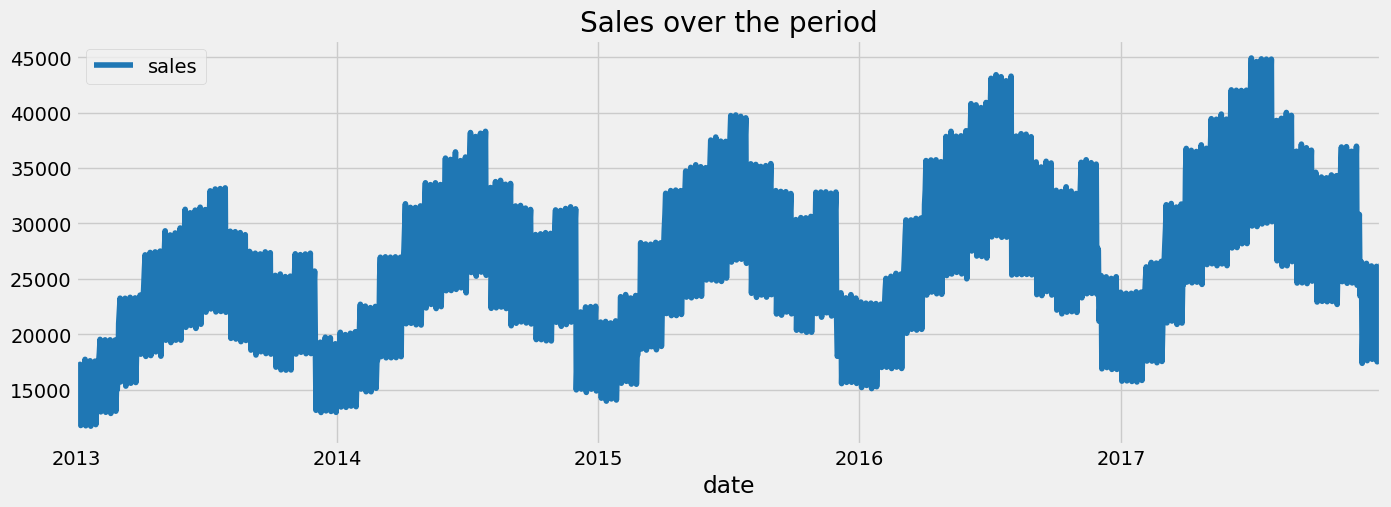

In [33]:
train_df.plot(
        # style='.',
        figsize=(15, 5),
        color=color_pallet[0],
        title='Sales over the period')
plt.show()

# splitting data to train and test

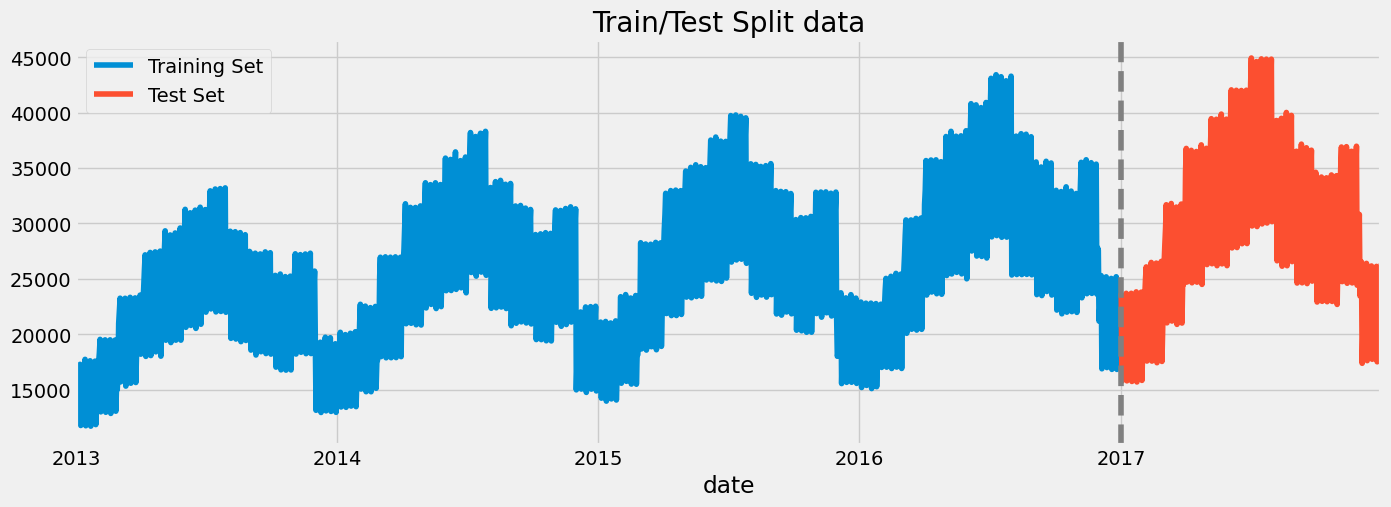

In [34]:
train = train_df.loc[train_df.index < '01-01-2017']
test = train_df.loc[train_df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Experimetns and Tuning

In [35]:
# before changing column name, we need to change data from index to column
train

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237
...,...
2016-12-27,19341
2016-12-28,19560
2016-12-29,21111


In [36]:
def to_prophet_format(df):
    # column name should be "ds" for date and "y" for value
    df = df.reset_index()
    df.columns = ['ds', 'y']
    return df

In [37]:
train = to_prophet_format(train)
test = to_prophet_format(test)

In [38]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5w3s0cz/lexiqeca.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5w3s0cz/8kcqjh9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59963', 'data', 'file=/tmp/tmpy5w3s0cz/lexiqeca.json', 'init=/tmp/tmpy5w3s0cz/8kcqjh9a.json', 'output', 'file=/tmp/tmpy5w3s0cz/prophet_modelpwjpjffs/prophet_model-20230627044110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:41:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
360,2017-12-27,22137.524215,19721.680138,24416.985562
361,2017-12-28,23769.875056,21425.755151,26007.949915
362,2017-12-29,25500.051008,22959.577522,27820.956226
363,2017-12-30,27170.790898,24932.259823,29400.288996
364,2017-12-31,28900.489629,26600.739363,31041.352437


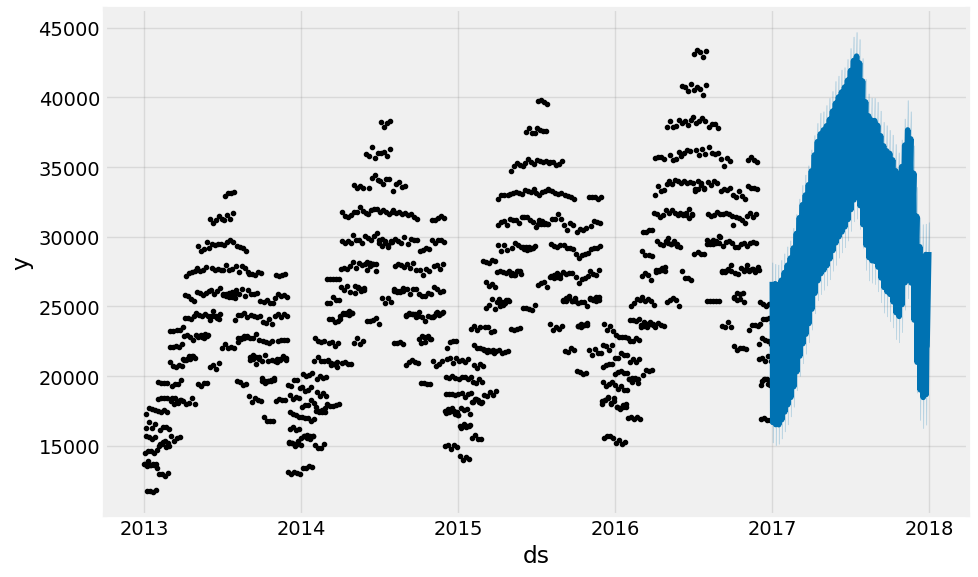

In [40]:
fig1 = m.plot(forecast)

## evaluation

In [41]:
mae = mean_absolute_error(forecast['yhat'], test['y'])
print('Mean abs error:', mae)

Mean abs error: 1463.2303164810976


## Save and load model

In [42]:
from prophet.serialize import model_to_json, model_from_json

with open(save_model_path, 'w') as fout:
    fout.write(model_to_json(m))  # Save model

with open(save_model_path, 'r') as fin:
    m_load = model_from_json(fin.read())  # Load model

/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


try loaded model

In [43]:
forecast_from_load = m_load.predict(test)
forecast_from_load[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
360,2017-12-27,22137.524215,19918.554600,24357.377887
361,2017-12-28,23769.875056,21486.198405,26141.732365
362,2017-12-29,25500.051008,23341.186418,27750.642493
363,2017-12-30,27170.790898,24770.388816,29365.574232
364,2017-12-31,28900.489629,26755.502943,31212.029092


## out-sample-prediction

In [47]:
future = list()
for i in range(1, 13):
    # starting after test data 2018
  date = '2018-%02d' % i
  future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

In [48]:
future_forecast = m.predict(future)
future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7,2018-08-01,36225.168712,34503.308827,38118.812998
8,2018-09-01,38563.925951,36742.997783,40456.732130
9,2018-10-01,28046.770177,26153.365913,30230.308803
10,2018-11-01,32632.623838,30325.059245,34867.130705
11,2018-12-01,32830.601659,30665.407509,35276.641811


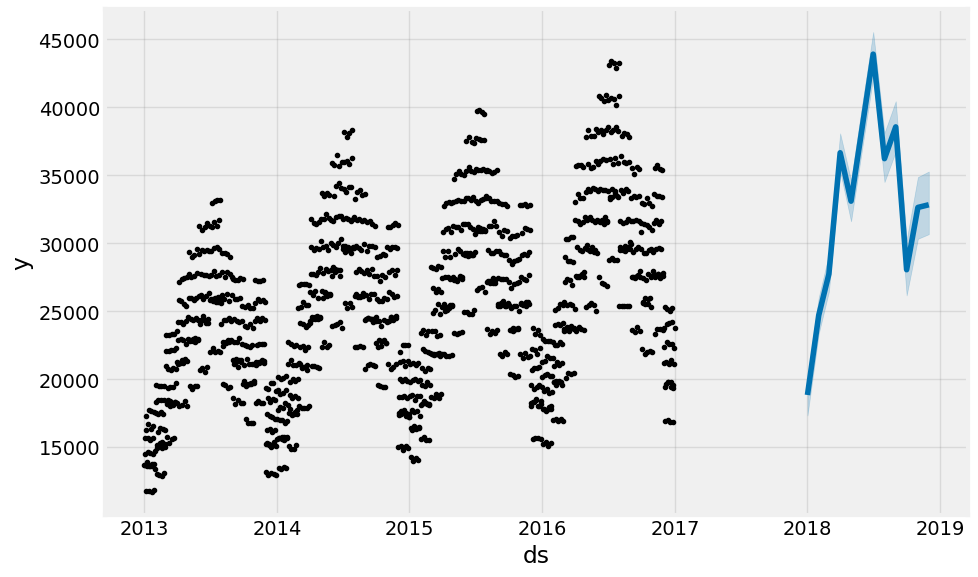

In [64]:
fig2 = m.plot(future_forecast)

## selected only 1 items

In [50]:
data = pd.read_csv(train_path)
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


lets see which item has the lowest sale

In [51]:
data.groupby('item').sum('sales').sort_values(by=['sales']).head(3)

,store,sales
item,,
5,100430,335230
1,100430,401384
41,100430,401759


In [52]:
item_id = 5
# try forecast item5
chosen_item = data[data['item'] == item_id]
chosen_item.head(5)

,date,store,item,sales
73040,2013-01-01,1,5,11
73041,2013-01-02,1,5,6
73042,2013-01-03,1,5,8
73043,2013-01-04,1,5,9
73044,2013-01-05,1,5,8


In [53]:
# preprocessing
chosen_item = preprocessing(chosen_item)

In [54]:
chosen_item['y-m'] = chosen_item.index\
    .to_series()\
    .apply(lambda x: pd.to_datetime(x.strftime('%Y-%-m')))

In [55]:
chosen_item

,sales,y-m
date,,
2013-01-01,83,2013-01-01
2013-01-02,81,2013-01-01
2013-01-03,96,2013-01-01
2013-01-04,108,2013-01-01
2013-01-05,100,2013-01-01
...,...,...
2017-12-27,148,2017-12-01
2017-12-28,157,2017-12-01
2017-12-29,177,2017-12-01


In [56]:
monthly_sale = chosen_item.groupby('y-m').sum('sales')
monthly_sale.head()

,sales
y-m,
2013-01-01,3103
2013-02-01,3220
2013-03-01,4307
2013-04-01,4729
2013-05-01,5392


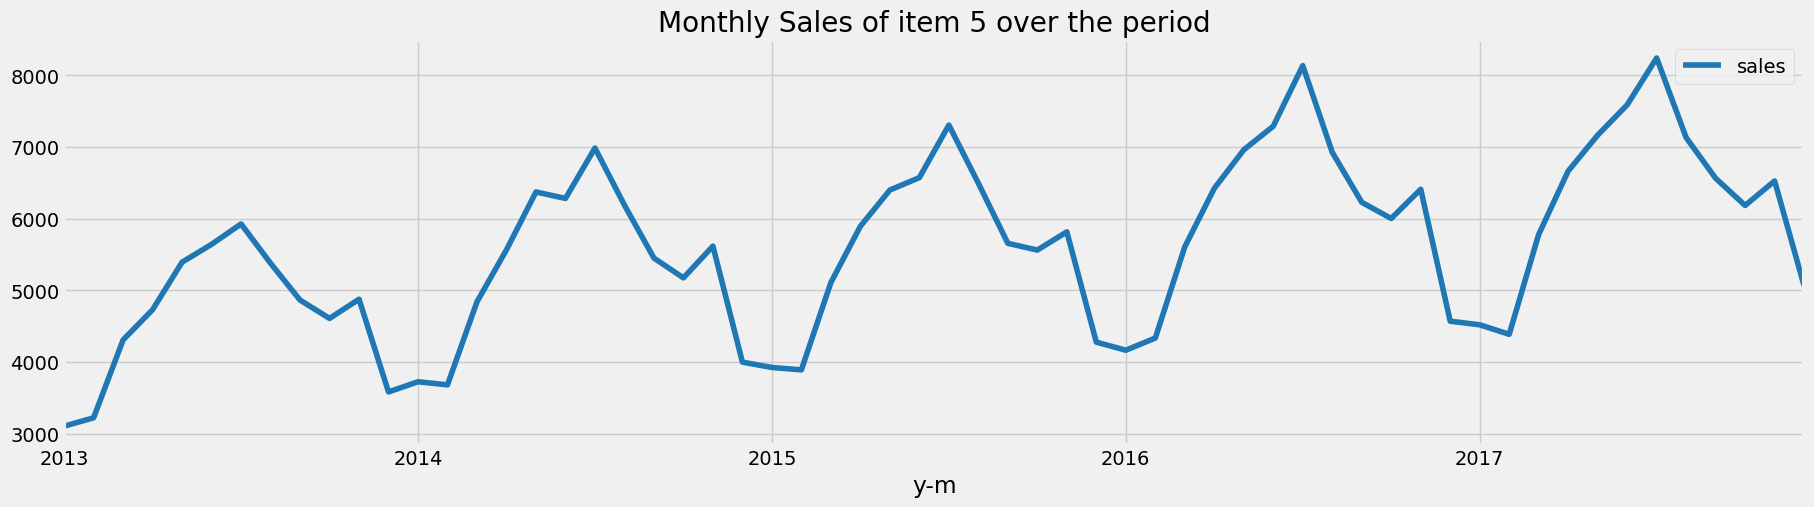

In [57]:
monthly_sale.plot(
        figsize=(20, 5),
        color=color_pallet[0],
        title='Monthly Sales of item 5 over the period')
plt.show()

In [58]:
# split train test of item 5
chosen_train = monthly_sale.loc[monthly_sale.index < '01-01-2017']
chosen_test = monthly_sale.loc[monthly_sale.index >= '01-01-2017']

In [59]:
# convert to prophet format
chosen_train = to_prophet_format(chosen_train)
chosen_test = to_prophet_format(chosen_test)

In [60]:
# create and fit modelt to the item 5 data
item_m = Prophet()
item_m.fit(chosen_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5w3s0cz/t7ob_snx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy5w3s0cz/7m7yxlj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48471', 'data', 'file=/tmp/tmpy5w3s0cz/t7ob_snx.json', 'init=/tmp/tmpy5w3s0cz/7m7yxlj4.json', 'output', 'file=/tmp/tmpy5w3s0cz/prophet_modelc33q7cqy/prophet_model-20230627044145.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:41:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:41:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [61]:
chosen_test_forecast = item_m.predict(chosen_test)
chosen_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7,2017-08-01,7480.823369,7333.912504,7627.355304
8,2017-09-01,6818.555161,6669.571569,6981.444520
9,2017-10-01,6584.198496,6424.528542,6732.929985
10,2017-11-01,6933.886554,6766.055729,7097.229991
11,2017-12-01,5323.167367,5164.532280,5481.270301


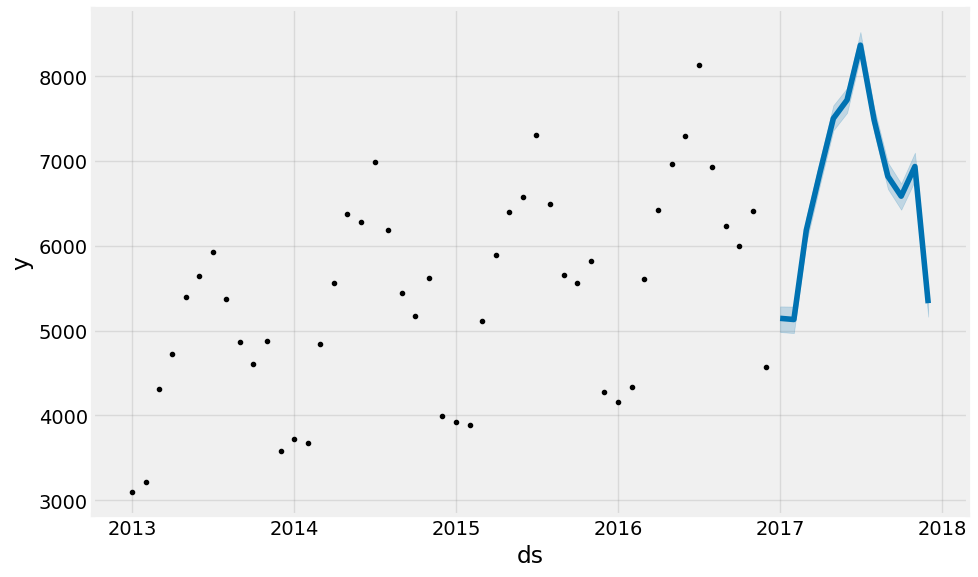

In [62]:
fig3 = item_m.plot(chosen_test_forecast)

In [63]:
mae = mean_absolute_error(chosen_test_forecast['yhat'], chosen_test['y'])
print('Mean abs error:', mae)

Mean abs error: 353.52791745336754
